## `Stochastic` (Non-Deterministic) Interpolator, $I_{\phi}$, Evaluation

* This is an evaluation NB for the 'stochastic' interpolators. See `interpolator_inference_dropout_crps.ipynb` for more in-depth analysis on the effect of dropout on the predictions.

### Evaluation Metrics:
* evaluate the **15 epoch** models on the following metrics:
    * `LPIPS`: perceptual score (more coherent with visual score than SSIM and VGG).
    * `MSE`: traditional. 
    * `MSE (reduction='sum')`: ~ MSE but also penalises over prediction of 0 more.
    * `CRPS & non-zero CRPS`: how well they preds match the distribution and the non-zero is to help with the skewed distribution.
    * `SSR`: spread-skill score. `"Reliability is quantified using the SSR, where an ideal ensemble model yields an SSR of 1.0."`
    * `CSI` at thresholds **2**, **10** and **18**.

In [1]:
import os
from pathlib import Path
from typing import Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy import io
import seaborn as sns
from omegaconf import OmegaConf
from scipy import io
from torch.utils.data import DataLoader
from torch.nn import MSELoss, L1Loss
from torchmetrics.image import LearnedPerceptualImagePatchSimilarity as LPIPS
from torchmetrics.regression import CriticalSuccessIndex
import xskillscore as xs
import xarray as xr

from rainnow.src.dyffusion.utilities.evaluation import (
    evaluate_ensemble_crps,
    evaluate_ensemble_spread_skill_ratio,
)
from rainnow.src.dyffusion.experiment_types.interpolation import InterpolationExperiment
from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.interpolator_evaluation import (
    eval_trained_interpolators,
    eval_single_trained_interpolator,
    get_an_interpolated_ensemble_batch,
    plot_ens_eval_single_t_interpolation,
)
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.utils import (
    get_device,
    enable_inference_dropout,
)
from rainnow.src.utilities.loading import (
    load_model_checkpoint_for_eval,
    instantiate_interpolator_model_ckpt_from_config,
    load_imerg_datamodule_from_config,
)
from rainnow.src.plotting import plot_a_sequence, plot_an_interpolated_sequence

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


#### `helpers.`

In [2]:
# ** DIR helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CKPT_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/results/"
CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# plotting helpers.
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# get device.
device = get_device()

Cuda installed! Running on GPU! (device = cuda)


#### `instantiate the dataloaders + get batch of data.`

In [3]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        # change this depending on what models you're testing.
        "window": 1,
        "horizon": 4,
        "prediction_horizon": 4,
        "sequence_dt": 2,
    },
)
# datamodule.setup("fit")
datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

# set up the dataloaders.
BATCH_SIZE = datamodule.hparams["batch_size"]
# train_dataloader = DataLoader(datamodule._data_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(datamodule._data_val, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(datamodule._data_test, batch_size=BATCH_SIZE, shuffle=False)
predict_dataloader = DataLoader(datamodule._data_predict, batch_size=BATCH_SIZE, shuffle=False)

[2024-12-18 17:31:44][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-12-18 17:31:44][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]


[2024-12-18 17:31:46][torch_datasets.py][INFO] --> creating VAL tensor dataset.
[2024-12-18 17:31:46][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-12-18 17:31:46][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-12-18 17:31:46][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-12-18 17:31:47][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-12-18 17:31:47][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-12-18 17:31:48][abstract_datamodule.py][INFO] -->  Dataset test size: 768
[2024-12-18 17:31:48][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-12-18 17:31:48][imerg_precipitation.py][INFO] --> predict data split: [202303070000, 202303100000]
[2024-12-18 17:31:48][to

In [4]:
# get a batch of data.
iter_loader = iter(predict_dataloader)
X = next(iter_loader)["dynamics"]

# debug info.
print(f"\n**  batch size = {BATCH_SIZE} **")
print(f"** num batches = {len(iter_loader)} **")
print(f"** num samples = {BATCH_SIZE * len(iter_loader)} ** ")
print(f"** sample dims: {X.shape}")  # (batch_size, sequence_length, channels, H, W)
print(f"** loaded sequence length = {datamodule.hparams.horizon + datamodule.hparams.window} **")


**  batch size = 6 **
** num batches = 3 **
** num samples = 18 ** 
** sample dims: torch.Size([6, 5, 1, 128, 128])
** loaded sequence length = 5 **


#### `instantiate PreProcess() object`

In [5]:
# instantiate the pprocessor object.
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-12-18 17:31:48][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


In [6]:
# fmt: off

# ckpt_id: <experiment description>
ckpt_dict = {
    # ** 15 epoch trains. **
    # ** 1/2 sequence length **
    # ** Batchnorm UNet final kernel Size = 4 **
    # LPIPS.
    "ipol-j9ba5lap": "LCB(α=.6) | dp:(0, .1, .3, .3)",
    "ipol-azpen1vk": "LCB(α=.6) | dp:(0, .2, .6, .6)",              # .33 LIPS (same IDs).
    "interpolation-k71rkbd0": "LCB(α=.6) | dp:(.2, .4, .7, .7)",
    "interpolation-xggwevja": "LCB(α=.6) | dp:(.3, .2, .7, .7)",
    "interpolation-lopmudym": "LCB(α=.6) dp:(.3, .2, .6, .6)",
    "interpolation-j7a41vfh": "LCB(α=.6) dp:(.4, .1, .3, .3)",
    "interpolation-yywxun9p": "LCB(α=.6) dp:(.4, .3, .7, .3)",
    "interpolation-nhax1bxg": "LCB(α=.6) dp:(.4, .3, .7, .8)",
    "interpolation-yn6mloms": "LCB(α=.6) | dp:(.4, .6, .85, .85)",  # .33 LIPS (same IDs).
    "interpolation-ifq0zic8": "LCB(α=.6) | dp:(.6, .4, .8, .8)",    # .33 LIPS (same IDs).     
    "interpolation-5eurdqhf": "LCB(α=.6) | dp:(.75, .75, .9, .9)",  # .33 LIPS (same IDs). 
    # .4, .3, .7, .8 @ different α (.33, & .9).
    "interpolation-p32wzr6p": "LCB(α=.9) | dp:(.3, .2, .6, .6)",
    "interpolation-aw7aqmu6": "LCB(α=.9) | dp:(.4, .3, .7, .8)",
    "interpolation-otiknefi": "LCB(α=.33) | dp:(.4, .3, .7, .8)",
    "interpolation-pzsmwjnb": "LCB(α=.33) | dp:(.2, .4, .8, .8)", 
    # WL.
    # "ipol-qpb60edp": "WL(ε=150.) | dp: (0, .1, .3, .3)",             
    # "ipol-bdslymv0": "WL(ε=150.) | dp: (0, .2, .6, .6)", 
    # "interpolation-zmka6woq": "WL(ε=150.) | dp: (4, .1, .3, .3)",            
    # "interpolation-imrvuhnn": "WL(ε=150.) | dp: (3, .2, .6, .6)", 
    # "interpolation-zsuynpxh": "WL(ε=150.) | dp: (.4, .3, .7, .8)",    
}

# fmt: on

#### `Load in an interpolator model(s) (UNet ResNet or Unet) for evaluation`

In [8]:
loaded_models = {}
for ckpt_id in ckpt_dict.keys():  # evaluate all models.
    print(f"** Getting model from ckpt_id: {ckpt_id} **\n")
    model = instantiate_interpolator_model_ckpt_from_config(
        ckpt_id=ckpt_id,
        model_ckpt_cfg_base_path=CKPT_BASE_PATH,
        cfg_base_path=CONFIGS_BASE_PATH,
        model_cfg_name=CKPT_CFG_NAME,
        datamodule_cfg_name=DATAMODULE_CONFIG_NAME,
    )
    model = load_model_checkpoint_for_eval(
        model=model, ckpt_id=ckpt_id, ckpt_base_path=CKPT_BASE_PATH, ckpt_dir=CKPT_DIR, get_last=GET_LAST
    )
    # enable monte-carlo randomness in dropout layers during inference.
    enable_inference_dropout(model)
    loaded_models[ckpt_id] = model

In [ ]:
# instantiate metrics.
lpips = LPIPS(reduction="mean", normalize=True).to(
    device
)  # set to True so that the function normalises to [-1, 1].
mse = MSELoss(reduction="mean")
mse_s = MSELoss(reduction="sum")
mae = L1Loss(reduction="mean")
csi_nodes = [2, 10, 18]
# need to get the nodes to the same scale as the data. See NB:  imerg_rainfall_classes.ipynb for rain classes + distributions.
normed_csi_nodes = pprocessor.apply_preprocessing(np.array(csi_nodes))
csi2 = CriticalSuccessIndex(threshold=normed_csi_nodes[0]).to(device)
csi10 = CriticalSuccessIndex(threshold=normed_csi_nodes[1]).to(device)
csi18 = CriticalSuccessIndex(threshold=normed_csi_nodes[-1]).to(device)

#### `Get Eval Metrics:`

In [ ]:
NUM_ENS_PREDS = 8
NON_ZERO_THD = 0.1

In [19]:
results = {}
with torch.no_grad():
    print("** Evaluation INFO: **")
    print(f"--> num ens preds = {NUM_ENS_PREDS}")
    print(f"--> non-zero threshold = {NON_ZERO_THD}\n")
    for _id in ckpt_dict.keys():
        # need to restart the dataloader for each model
        iter_loader = iter(test_dataloader)
        model = loaded_models[_id].to(device)
        # ** eval mode **
        model.eval()
        # enable monte-carlo randomness in dropout layers during inference.
        enable_inference_dropout(model)
        assert all(
            layer.training
            for layer in model.modules()
            if isinstance(layer, (torch.nn.Dropout, torch.nn.Dropout2d))
        ), f"Not all dropout layers are in training mode for model."

        # reset the losses.
        l2_score = 0
        l2_score_red_sum = 0  # penalises over pred of 0 mmh-1.
        l1_score = 0
        lpips_score = 0
        csi2_score = 0  # low rain.
        csi10_score = 0  # mid rain.
        csi18_score = 0  # heavy rain.
        crps_score = 0
        nonzero_crps_score = 0
        ssr_score = 0
        nonzero_ssr_score = 0

        for e, _input in tqdm(
            enumerate(iter_loader), total=len(iter_loader), desc=f"Evaluating model {_id}"
        ):
            # get 'dynamic' data from batch and send to device.
            x = _input["dynamics"].to(device)

            # get x0, interpolated values and xh from X.
            x0 = x[:, 0, :, :, :].to(device)
            xh = x[:, -1, :, :, :].to(device)
            targets = x[:, 1:-1, :, :, :].to(device)

            H, W = 128, 128

            interp_ens = {}
            interp_mean = {}
            for t in range(1, targets.size(1) + 1):
                # ens preds at a given time, t.
                t_interp = model(
                    torch.concat([x0, xh], dim=1).repeat(NUM_ENS_PREDS, 1, 1, 1).to(device),
                    time=torch.tensor([t], dtype=torch.long).to(device),
                ).to(device)
                t_interp = torch.stack(
                    torch.chunk(t_interp, NUM_ENS_PREDS, dim=0), dim=0
                )  # (N, B, C, H, W).
                interp_ens[f"t{t}"] = t_interp
                interp_mean[f"t{t}"] = t_interp.mean(dim=0)

            # reshape interpolations into shape ((num ens), B, num_interps, H, W)
            ens_preds = torch.concat([v.detach() for _, v in interp_ens.items()], axis=2).unsqueeze(
                dim=3
            )  # (N, B, t, C, H, W)
            preds = torch.concat([v.detach() for _, v in interp_mean.items()], axis=1).unsqueeze(
                dim=2
            )  # (B, t, C, H, W)

            # unnorm tanh activated outputs: [-1, 1] --> [0, 1].
            if isinstance(model.final_conv[1], nn.Tanh):
                ens_preds = (ens_preds + 1) / 2
                preds = (preds + 1) / 2

            preds_reshaped = preds.reshape(-1, 1, H, W)
            targets_reshaped = targets.reshape(-1, 1, H, W)

            # get deterministic metrics:
            # avg. batch losses:
            l2_score += mse(preds, targets)
            l2_score_red_sum += mse_s(preds, targets)
            l1_score += mse(preds, targets)
            # need to clip to 100% ensure that inputs to LPIPs [0, 1]. The data also needs to be 3 channels for LPIPs.
            lpips_score += lpips(
                torch.clip(preds_reshaped, min=0, max=1).expand(-1, 3, -1, -1),
                torch.clip(targets_reshaped, min=0, max=1).expand(-1, 3, -1, -1),
            )
            csi2_score += csi2(preds, targets)
            csi10_score += csi10(preds, targets)
            csi18_score += csi18(preds, targets)

            # get probabilistic metrics:
            # zero mask:
            mask = targets > NON_ZERO_THD
            ens_mask = mask.unsqueeze(0).repeat(NUM_ENS_PREDS, *[1] * mask.dim())
            masked_ens = ens_preds[ens_mask].view(NUM_ENS_PREDS, -1)

            # crps.
            crps = evaluate_ensemble_crps(ens_preds.cpu(), targets.cpu(), mean_over_samples=True)
            crps_nonzero = evaluate_ensemble_crps(
                masked_ens.cpu(), targets[mask].cpu(), mean_over_samples=True
            )
            crps_score += crps
            nonzero_crps_score += crps_nonzero
            # ssr.
            ssr = evaluate_ensemble_spread_skill_ratio(ens_preds.cpu().numpy(), targets.cpu().numpy())
            ssr_nonzero = evaluate_ensemble_spread_skill_ratio(
                masked_ens.cpu().numpy(), targets[mask].cpu().numpy()
            )
            ssr_score += ssr
            nonzero_ssr_score += ssr_nonzero

        results[_id] = {
            "L2('mean')": l2_score.item() / len(iter_loader),
            "L2('sum')": l2_score_red_sum.item() / len(iter_loader),
            "L1('mean')": l1_score.item() / len(iter_loader),
            "lpips": lpips_score.item() / len(iter_loader),
            "crps": crps_score / len(iter_loader),
            "crps_nonzero": crps_nonzero / len(iter_loader),
            "ssr": ssr_score / len(iter_loader),
            "ssr_nonzero": ssr_nonzero / len(iter_loader),
            "csi2": csi2_score.item() / len(iter_loader),
            "csi10": csi10_score.item() / len(iter_loader),
            "csi18": csi18_score.item() / len(iter_loader),
        }

# create df, format it and export it to a .csv.
df_results = pd.DataFrame(results)
df_results_formatted = df_results.rename(columns=ckpt_dict)
df_results_formatted.to_csv("results/interp_prob_eval_metrics.csv")
df_results_formatted

** Evaluation INFO: **
--> num ens preds = 8
--> non-zero threshold = 0.1



Evaluating model ipol-j9ba5lap:   0%|          | 0/126 [00:00<?, ?it/s]

Evaluating model interpolation-pzsmwjnb: 100%|██████████| 126/126 [03:29<00:00,  1.66s/it]


,"LCB(α=.6) | dp:(0, .1, .3, .3)","LCB(α=.6) | dp:(0, .2, .6, .6)","LCB(α=.6) | dp:(.2, .4, .7, .7)","LCB(α=.6) | dp:(.3, .2, .7, .7)","LCB(α=.6) dp:(.3, .2, .6, .6)","LCB(α=.6) dp:(.4, .1, .3, .3)","LCB(α=.6) dp:(.4, .3, .7, .8)","LCB(α=.6) | dp:(.4, .6, .85, .85)","LCB(α=.6) | dp:(.6, .4, .8, .8)","LCB(α=.6) | dp:(.75, .75, .9, .9)","LCB(α=.9) | dp:(.3, .2, .6, .6)","LCB(α=.9) | dp:(.4, .3, .7, .8)","LCB(α=.33) | dp:(.4, .3, .7, .8)","LCB(α=.33) | dp:(.2, .4, .8, .8)"
L2('mean'),0.000931,0.000930,0.000932,0.000968,0.000988,0.000951,0.000931,0.000912,0.000949,0.000897,0.001140,0.000942,0.000921,0.000936
L2('sum'),272.992405,272.640873,273.515191,284.060981,289.996683,279.003131,273.035311,267.526662,278.514013,263.028305,334.656963,276.274833,270.256820,274.573475
L1('mean'),0.000931,0.000930,0.000932,0.000968,0.000988,0.000951,0.000931,0.000912,0.000949,0.000897,0.001140,0.000942,0.000921,0.000936
lpips,0.115804,0.116379,0.117707,0.118737,0.118975,0.116290,0.118768,0.120477,0.121466,0.123989,0.130513,0.125315,0.117590,0.119116
crps,0.009073,0.008854,0.008724,0.008871,0.009071,0.008901,0.008680,0.008382,0.008413,0.008114,0.009807,0.008940,0.008382,0.008497
crps_nonzero,0.000697,0.000719,0.000654,0.000648,0.000634,0.000665,0.000647,0.000703,0.000689,0.000683,0.000586,0.000591,0.000695,0.000706
ssr,0.095540,0.130422,0.185758,0.177317,0.183170,0.165059,0.198967,0.227171,0.257577,0.310661,0.145354,0.178877,0.213088,0.191288
ssr_nonzero,0.000511,0.000670,0.001090,0.001067,0.001167,0.000985,0.001182,0.001283,0.001510,0.001738,0.000944,0.001062,0.001252,0.001107
csi2,0.350499,0.338243,0.350568,0.352441,0.351393,0.347445,0.350900,0.333404,0.338399,0.333424,0.358064,0.360369,0.338941,0.341436
csi10,0.176091,0.161049,0.178878,0.184370,0.184999,0.170763,0.174021,0.149082,0.175879,0.143547,0.199264,0.178507,0.174010,0.183227


In [33]:
# load in exported results.
df_results_formatted = pd.read_csv("results/interp_prob_eval_metrics.csv")
df_results_formatted.set_index("Unnamed: 0", inplace=True, drop=True)
df_results_formatted

,"LCB(α=.6) | dp:(0, .1, .3, .3)","LCB(α=.6) | dp:(0, .2, .6, .6)","LCB(α=.6) | dp:(.2, .4, .7, .7)","LCB(α=.6) | dp:(.3, .2, .7, .7)","LCB(α=.6) dp:(.3, .2, .6, .6)","LCB(α=.6) dp:(.4, .1, .3, .3)","LCB(α=.6) dp:(.4, .3, .7, .8)","LCB(α=.6) | dp:(.4, .6, .85, .85)","LCB(α=.6) | dp:(.6, .4, .8, .8)","LCB(α=.6) | dp:(.75, .75, .9, .9)","LCB(α=.9) | dp:(.3, .2, .6, .6)","LCB(α=.9) | dp:(.4, .3, .7, .8)","LCB(α=.33) | dp:(.4, .3, .7, .8)","LCB(α=.33) | dp:(.2, .4, .8, .8)"
Unnamed: 0,,,,,,,,,,,,,,
L2('mean'),0.000931,0.000930,0.000932,0.000968,0.000988,0.000951,0.000931,0.000912,0.000949,0.000897,0.001140,0.000942,0.000921,0.000936
L2('sum'),272.992405,272.640873,273.515191,284.060981,289.996683,279.003131,273.035311,267.526662,278.514013,263.028305,334.656963,276.274833,270.256820,274.573475
L1('mean'),0.000931,0.000930,0.000932,0.000968,0.000988,0.000951,0.000931,0.000912,0.000949,0.000897,0.001140,0.000942,0.000921,0.000936
lpips,0.115804,0.116379,0.117707,0.118737,0.118975,0.116290,0.118768,0.120477,0.121466,0.123989,0.130513,0.125315,0.117590,0.119116
crps,0.009073,0.008854,0.008724,0.008871,0.009071,0.008901,0.008680,0.008382,0.008413,0.008114,0.009807,0.008940,0.008382,0.008497
crps_nonzero,0.000697,0.000719,0.000654,0.000648,0.000634,0.000665,0.000647,0.000703,0.000689,0.000683,0.000586,0.000591,0.000695,0.000706
ssr,0.095540,0.130422,0.185758,0.177317,0.183170,0.165059,0.198967,0.227171,0.257577,0.310661,0.145354,0.178877,0.213088,0.191288
ssr_nonzero,0.000511,0.000670,0.001090,0.001067,0.001167,0.000985,0.001182,0.001283,0.001510,0.001738,0.000944,0.001062,0.001252,0.001107
csi2,0.350499,0.338243,0.350568,0.352441,0.351393,0.347445,0.350900,0.333404,0.338399,0.333424,0.358064,0.360369,0.338941,0.341436


In [34]:
# cols to use for analysis.
metric_cols = ["L2('mean')", "L2('sum')", "lpips", "crps", "ssr", "csi2", "csi10", "csi18"]

In [21]:
# # WL results.
# wl_models = [i for i in df_results_formatted.columns if i[:2] == "WL"]
# wl_results = df_results_formatted[wl_models].T[metric_cols].sort_index()
# wl_results

In [32]:
# LPIPS results.
lpips_models = [i for i in df_results_formatted.columns if i[:3] == "LCB"]
lpips_results = df_results_formatted[lpips_models].T[metric_cols].sort_index()
lpips_results

Unnamed: 0,L2('mean'),L2('sum'),lpips,crps,ssr,csi2,csi10,csi18
"LCB(α=.33) | dp:(.2, .4, .8, .8)",0.000936,274.573475,0.119116,0.008497,0.191288,0.341436,0.183227,0.083776
"LCB(α=.33) | dp:(.4, .3, .7, .8)",0.000921,270.256820,0.117590,0.008382,0.213088,0.338941,0.174010,0.061706
"LCB(α=.6) dp:(.3, .2, .6, .6)",0.000988,289.996683,0.118975,0.009071,0.183170,0.351393,0.184999,0.065498
"LCB(α=.6) dp:(.4, .1, .3, .3)",0.000951,279.003131,0.116290,0.008901,0.165059,0.347445,0.170763,0.061371
"LCB(α=.6) dp:(.4, .3, .7, .8)",0.000931,273.035311,0.118768,0.008680,0.198967,0.350900,0.174021,0.036554
"LCB(α=.6) | dp:(.2, .4, .7, .7)",0.000932,273.515191,0.117707,0.008724,0.185758,0.350568,0.178878,0.053105
"LCB(α=.6) | dp:(.3, .2, .7, .7)",0.000968,284.060981,0.118737,0.008871,0.177317,0.352441,0.184370,0.062626
"LCB(α=.6) | dp:(.4, .6, .85, .85)",0.000912,267.526662,0.120477,0.008382,0.227171,0.333404,0.149082,0.036681
"LCB(α=.6) | dp:(.6, .4, .8, .8)",0.000949,278.514013,0.121466,0.008413,0.257577,0.338399,0.175879,0.052009
"LCB(α=.6) | dp:(.75, .75, .9, .9)",0.000897,263.028305,0.123989,0.008114,0.310661,0.333424,0.143547,0.009120


In [35]:
# get SSR, CRPS and CSI values vs. Dropout.
input_dropouts = [eval(i.split(":")[-1])[0] for i in lpips_results.index]
accumulative_dropouts = [sum(eval(i.split(":")[-1])) for i in lpips_results.index]
mean_dropouts = [np.mean(eval(i.split(":")[-1])) for i in lpips_results.index]

_ssr = lpips_results.ssr.values
_crps = lpips_results.crps.values

_csi2 = lpips_results.csi2.values
_csi10 = lpips_results.csi10.values
_csi18 = lpips_results.csi18.values

input_ssr = sorted(list(zip(input_dropouts, _ssr)), key=lambda x: x[0])
input_crps = sorted(list(zip(input_dropouts, _crps)), key=lambda x: x[0])
mean_ssr = sorted(list(zip(mean_dropouts, _ssr)), key=lambda x: x[0])
mean_crps = sorted(list(zip(mean_dropouts, _crps)), key=lambda x: x[0])

input_csi2 = sorted(list(zip(input_dropouts, _csi2)), key=lambda x: x[0])
input_csi10 = sorted(list(zip(input_dropouts, _csi10)), key=lambda x: x[0])
input_csi18 = sorted(list(zip(input_dropouts, _csi18)), key=lambda x: x[0])

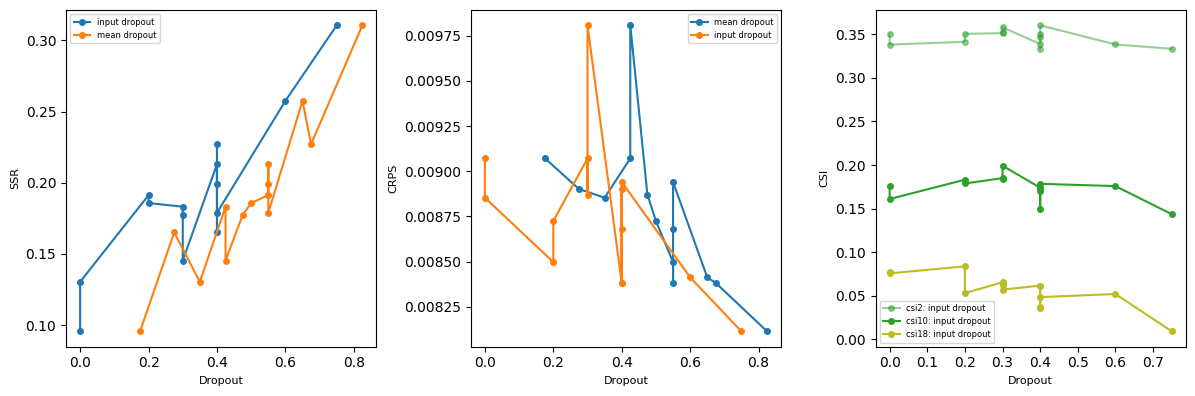

In [36]:
global_params = {
    "font.size": 8,
    # "font.family": "Times New Roman",
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plt.rcParams.update(**global_params)

axs[0].plot(
    [i[0] for i in input_ssr], [i[1] for i in input_ssr], marker="o", markersize=4, label="input dropout"
)
axs[0].plot(
    [i[0] for i in mean_ssr], [i[1] for i in mean_ssr], marker="o", markersize=4, label="mean dropout"
)
axs[0].set_ylabel("SSR", fontsize=8)
axs[0].set_xlabel("Dropout", fontsize=8)
axs[0].legend(loc="best", fontsize=6)

axs[1].plot(
    [i[0] for i in mean_crps], [i[1] for i in mean_crps], marker="o", markersize=4, label="mean dropout"
)
axs[1].plot(
    [i[0] for i in input_crps],
    [i[1] for i in input_crps],
    marker="o",
    markersize=4,
    label="input dropout",
)
axs[1].set_ylabel("CRPS", fontsize=8)
axs[1].set_xlabel("Dropout", fontsize=8)
axs[1].legend(loc="best", fontsize=6)

axs[2].plot(
    [i[0] for i in input_csi2],
    [i[1] for i in input_csi2],
    color="C2",
    alpha=0.5,
    marker="o",
    markersize=4,
    label="csi2: input dropout",
)
axs[2].plot(
    [i[0] for i in input_csi10],
    [i[1] for i in input_csi10],
    color="C2",
    linestyle="-",
    marker="o",
    markersize=4,
    label="csi10: input dropout",
)
axs[2].plot(
    [i[0] for i in input_csi18],
    [i[1] for i in input_csi18],
    color="C8",
    marker="o",
    markersize=4,
    label="csi18: input dropout",
)
axs[2].set_ylabel("CSI", fontsize=8)
axs[2].set_xlabel("Dropout", fontsize=8)
axs[2].legend(loc="best", fontsize=6)

plt.tight_layout()

In [37]:
def plot_eval_metrics(results, metric_to_plot, figsize=(12, 5), key_coords=(0.05, 0.95), fontsize=8):
    """Wrapper function to plot eval metrics."""
    m = metric_to_plot.lower()
    fig, axs = plt.subplots(figsize=figsize)
    _x = range(len(results.T[m]))
    _y = results.T[m].values
    axs.plot(_x, _y, marker="o", zorder=1)
    axs.set_title(f"Ensemble {m.upper()} w/ Different Dropout Configurations", fontsize=fontsize)
    axs.set_ylabel(m.upper())
    axs.set_xticks(_x)
    axs.set_xticklabels(
        [i.split("w/")[0] for i in results.T[m].index], rotation=75, ha="right", fontsize=6
    )
    dropouts = [i.split(":")[-1] for i in results.T[m].index]
    for i, txt in enumerate(dropouts):
        axs.annotate(
            txt,
            (_x[i], _y[i]),
            textcoords="offset points",
            xytext=(0, 6),
            ha="center",
            fontsize=7,
            rotation=0,
        )
    axs.text(
        key_coords[0],
        key_coords[1],
        "dropouts: (input, block1, block2, attn)",
        transform=axs.transAxes,
        fontsize=fontsize,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

#### `SSR`

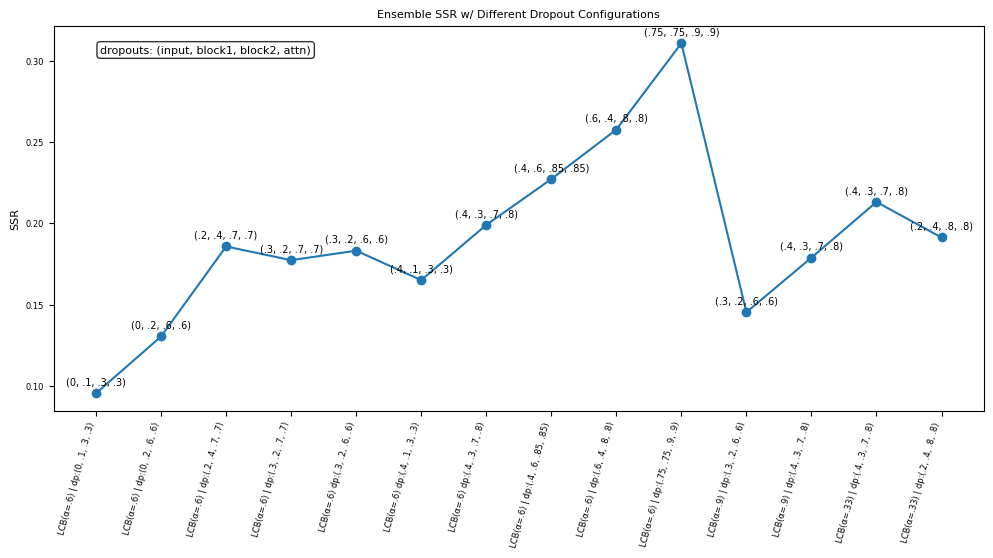

In [38]:
plot_eval_metrics(results=df_results_formatted, metric_to_plot="ssr", figsize=(12, 5))

#### `CRPS`

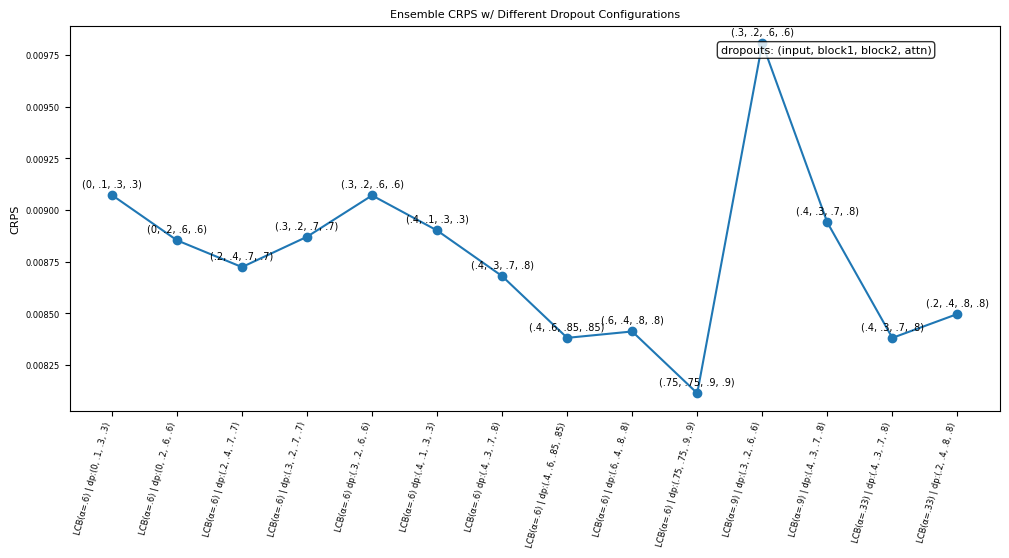

In [27]:
plot_eval_metrics(
    results=df_results_formatted, metric_to_plot="crps", figsize=(12, 5), key_coords=(0.7, 0.95)
)

In [2]:
# ** plot the last batch ** (visual confirmation)
fig, axs = plt.subplots(nrows=x.size(0), ncols=x.size(1), figsize=(12, 8))
for r in range(x.size(0)):
    for c in range(x.size(1)):
        axs[r, c].imshow(x[r, c, 0, :, :].cpu(), cmap=rain_cmap)
        axs[r, c].axis("off")
        axs[r, c].set_title(f"b={r}, t={c}", fontsize=8)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()

In [1]:
t = 1
ncols = targets.size(0)
nrows = ens_preds.size(0) + 2
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 24))
fontsize = 6
for j in range(nrows):
    for i in range(ncols):
        if j == nrows - 2:
            # plot mean preds.
            axs[j, i].imshow(preds[i, t, 0, :, :].detach().cpu(), cmap=rain_cmap)
            axs[j, i].set_title(f"mu (t={t})", fontsize=fontsize)
        elif j == nrows - 1:
            # plot targets.
            axs[j, i].imshow(targets[i, t, 0, :, :].detach().cpu(), cmap=rain_cmap)
            axs[j, i].set_title(f"target (t={t})", fontsize=fontsize)
        else:
            axs[j, i].imshow(ens_preds[j, i, t, 0, :, :].detach().cpu(), cmap=rain_cmap)
            axs[j, i].set_title(f"t={t} $ens_{j}$", fontsize=fontsize)
        axs[j, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()

#### END OF SCRIPT.